## Interactively install packages as needed

The below cells show how to install/upgrade packages on the cluster using pip, interactively. No kernel restart needed.

In [1]:
import os
import dask
from dask.distributed import Client
from azureml.core import Run

In [2]:
packages = 'matplotlib dask-lightgbm'

def update_packages(packages):
    os.system(f'pip install --upgrade {packages}')

In [3]:
run = Run.get_context()


In [4]:
c = Client(f'{run.get_metrics()["scheduler"]}')
c

Client Scheduler: tcp://10.0.0.23:8786 Dashboard: http://10.0.0.23:8787/status,Cluster Workers: 20 Cores: 320 Memory: 2.37 TB


In [5]:
nodes = 20

to_compute = dask.delayed([dask.delayed(update_packages)(packages) for i in range(nodes)])
to_compute.compute();

In [6]:
c.restart()

Client Scheduler: tcp://10.0.0.23:8786 Dashboard: http://10.0.0.23:8787/status,Cluster Workers: 20 Cores: 320 Memory: 2.37 TB


## Connect to cluster

In [7]:
import os
import dask
import joblib
import fsspec
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from dask_ml.xgboost import XGBRegressor
from dask_lightgbm import LGBMRegressor

from azureml.core import Run, Model

%matplotlib inline

In [8]:
run = Run.get_context()
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-cloudprovider,dask-cloudprovider_1584247087_1e302380,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


In [9]:
c = Client(f'{run.get_metrics()["scheduler"]}')
c

Client Scheduler: tcp://10.0.0.23:8786 Dashboard: http://10.0.0.23:8787/status,Cluster Workers: 20 Cores: 320 Memory: 2.37 TB


## Read data

Conveniently, the datastore is mounted so it can be viewed/operated on as if local. However, for reading into the distributed cluster, we will use ADLS's HDFS driver.

In [10]:
STORAGE_OPTIONS = {
    'account_name': run.experiment.workspace.get_default_datastore().account_name,
    'account_key' : run.experiment.workspace.get_default_datastore().account_key
}

protocol  = 'abfs'      # change to 'adl' for gen 1
container = run.experiment.workspace.get_default_datastore().container_name

In [11]:
fs = fsspec.filesystem(protocol, **STORAGE_OPTIONS)

In [12]:
files = fs.glob(f'{container}/noaa-isd/year=*/month=*/*.parquet') # adjust size of data if needed
files = [f'{protocol}://{file}' for file in files]  
files[-5:]

['abfs://default/noaa-isd/year=2020/month=3/part-00005-tid-8661374706919261253-da88c033-7bc5-4f5a-b5b9-d8bb3e0cea1e-1968-3.c000.snappy.parquet',
 'abfs://default/noaa-isd/year=2020/month=3/part-00006-tid-3885831618057415937-9715e54c-7a20-4936-96e9-5938bd33d1d0-1971-3.c000.snappy.parquet',
 'abfs://default/noaa-isd/year=2020/month=3/part-00006-tid-8661374706919261253-da88c033-7bc5-4f5a-b5b9-d8bb3e0cea1e-1969-3.c000.snappy.parquet',
 'abfs://default/noaa-isd/year=2020/month=3/part-00007-tid-3885831618057415937-9715e54c-7a20-4936-96e9-5938bd33d1d0-1966-3.c000.snappy.parquet',
 'abfs://default/noaa-isd/year=2020/month=3/part-00007-tid-8661374706919261253-da88c033-7bc5-4f5a-b5b9-d8bb3e0cea1e-1975-3.c000.snappy.parquet']

In [13]:
df = dd.read_parquet(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).repartition(npartitions=200).persist()
%time df.head()

CPU times: user 310 ms, sys: 41.4 ms, total: 351 ms
Wall time: 1min 43s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,999999,53878,2008-01-10 18:30:00,35.419,-82.557,641.0,NaN,NaN,7.4,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 13 S,US,999999-53878,2008,10,1.0
1,999999,53877,2008-01-06 13:45:00,35.495,-82.614,656.0,NaN,NaN,1.4,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 8 SSW,US,999999-53877,2008,6,1.0
2,999999,53878,2008-01-29 14:35:00,35.419,-82.557,641.0,NaN,NaN,7.3,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 13 S,US,999999-53878,2008,29,1.0
3,999999,53877,2008-01-04 05:25:00,35.495,-82.614,656.0,NaN,NaN,-11.4,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 8 SSW,US,999999-53877,2008,4,1.0
4,999999,53878,2008-01-12 00:30:00,35.419,-82.557,641.0,NaN,NaN,5.7,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 13 S,US,999999-53878,2008,12,1.0


In [14]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=True).persist()
%time len(df)

/azureml-envs/azureml_dc47200d9b15811b70e3679097613f52/lib/python3.6/site-packages/dask/dataframe/shuffle.py:746: UserWarning: Partition indices have overlap.
  warnings.warn("Partition indices have overlap.")


CPU times: user 204 ms, sys: 20.6 ms, total: 225 ms
Wall time: 27.8 s


1589272899

In [15]:
%time len(df)

CPU times: user 119 ms, sys: 12.1 ms, total: 131 ms
Wall time: 301 ms


1589272899

## Explore data

In [16]:
%time df.describe().compute()

CPU times: user 11.4 s, sys: 211 ms, total: 11.7 s
Wall time: 5min 35s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.589273e+09,1.589273e+09,1.589273e+09,1.278678e+09,1.327858e+09,1.558996e+09,5.725038e+08,1.463293e+08,5.876050e+07,3.395403e+08,3.395403e+08,9.802974e+06,1.589273e+09,1.589273e+09,1.589273e+09
mean,3.731136e+01,-3.919254e+01,3.965798e+02,1.654112e+02,3.440744e+00,1.179619e+01,1.014683e+03,3.050895e+01,4.245664e+00,1.012448e+01,1.228833e+03,1.759772e+01,2.014421e+03,1.566897e+01,1.000000e+00
std,2.176827e+01,7.852738e+01,6.350231e+02,1.144749e+02,2.871177e+00,1.255340e+01,9.439091e+00,2.948523e+01,3.005353e+00,2.177372e+01,3.269401e+03,3.234732e+01,3.655106e+00,8.816265e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.403300e+01,-9.521800e+01,4.500000e+01,9.000000e+01,2.000000e+00,8.000000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,4.161600e+01,-7.115000e+01,2.000000e+02,1.910000e+02,3.600000e+00,1.600000e+01,1.017200e+03,5.000000e+01,5.000000e+00,3.000000e+00,0.000000e+00,1.500000e+01,2.017000e+03,1.600000e+01,1.000000e+00
75%,4.917300e+01,1.769700e+01,5.480000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.025800e+03,7.100000e+01,8.000000e+00,1.200000e+01,9.999000e+03,6.300000e+01,2.020000e+03,2.400000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.020000e+03,3.100000e+01,1.000000e+00


In [17]:
%time places = df.groupby(df.index)[['longitude', 'latitude', 'year']].mean().compute()

CPU times: user 183 ms, sys: 4.22 ms, total: 187 ms
Wall time: 11.2 s


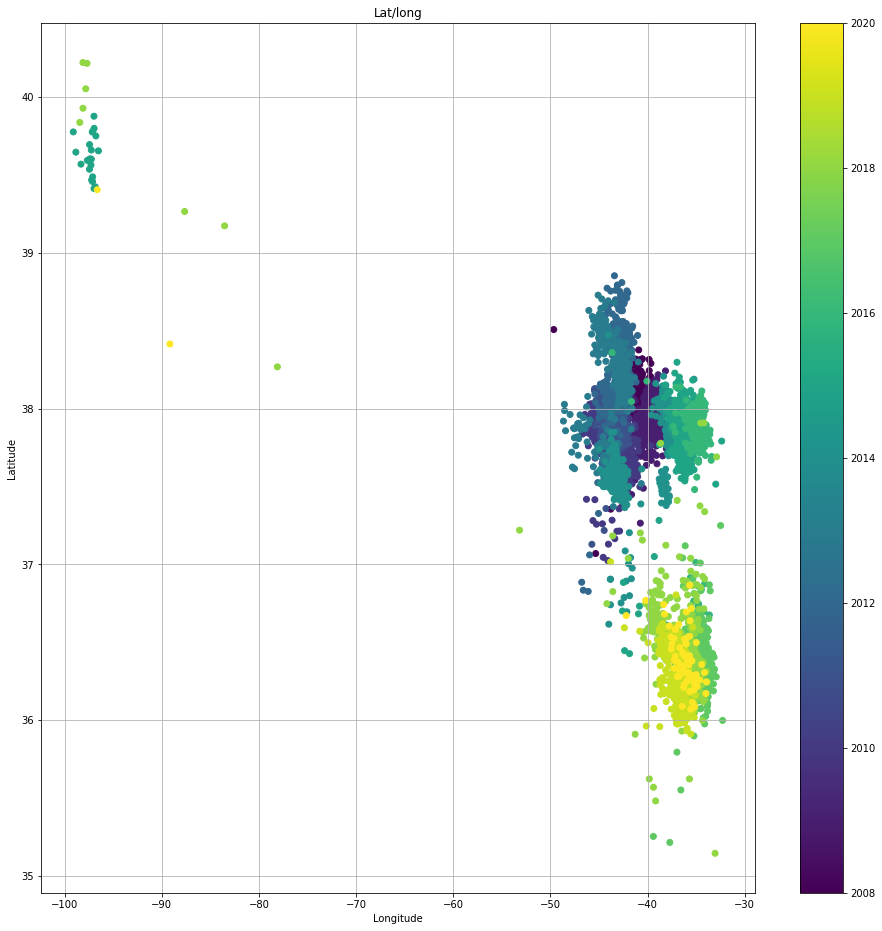

In [18]:
plt.figure(figsize=(16, 16))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.colorbar()

#run.log_image(f'lat_long', plot=plt) # log image to run

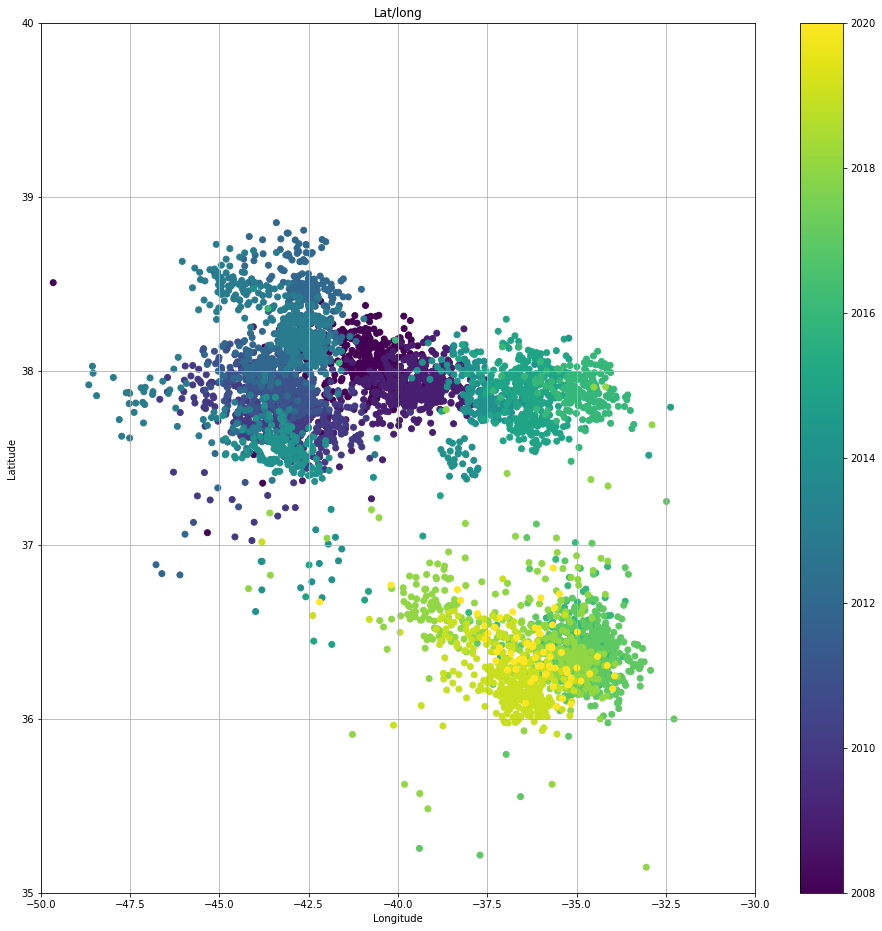

In [19]:
plt.figure(figsize=(16, 16))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-50, -30]) # zoom in 
plt.ylim([35, 40])   # zoom in 
plt.grid()
plt.colorbar()

run.log_image(f'lat_long_zoomed', plot=plt) # log image to run 

In [20]:
%time means = df.groupby(df.index).mean().compute()
means.head()

CPU times: user 247 ms, sys: 11.8 ms, total: 259 ms
Wall time: 26 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
2008-01-01,37.851544,-41.404520,351.706004,176.364994,4.031225,0.791217,1021.312605,29.191647,4.171073,5.199203,47.503108,21.776100,2008.0,1.0,1.0
2008-01-02,37.774122,-40.943714,352.504602,180.436673,4.306232,-0.932920,1021.165374,32.632597,4.152460,5.355434,44.483105,22.627133,2008.0,2.0,1.0
2008-01-03,37.781321,-40.130623,352.634351,156.904648,4.358461,-0.866068,1020.247739,32.471547,4.119097,5.402424,47.639126,23.396628,2008.0,3.0,1.0
2008-01-04,37.879647,-40.516726,353.027684,149.716467,4.318913,1.212171,1017.653427,30.277898,3.897811,5.524803,39.277930,22.328746,2008.0,4.0,1.0
2008-01-05,37.956239,-41.565558,358.450412,161.096456,4.328847,3.918379,1013.838332,30.640481,4.154117,5.342658,39.990708,23.943632,2008.0,5.0,1.0


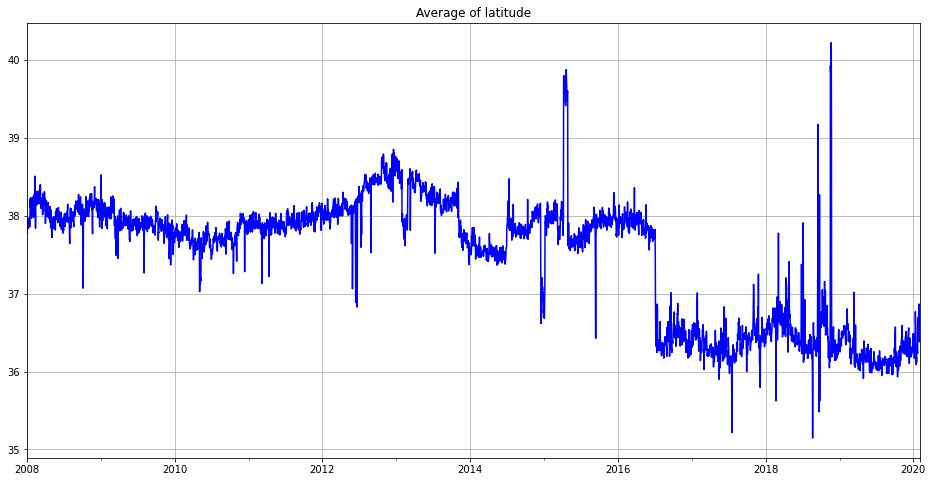

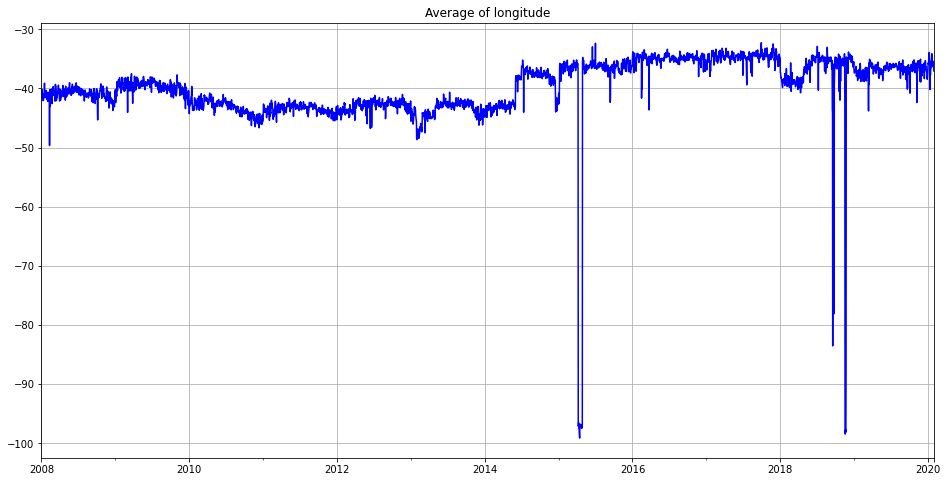

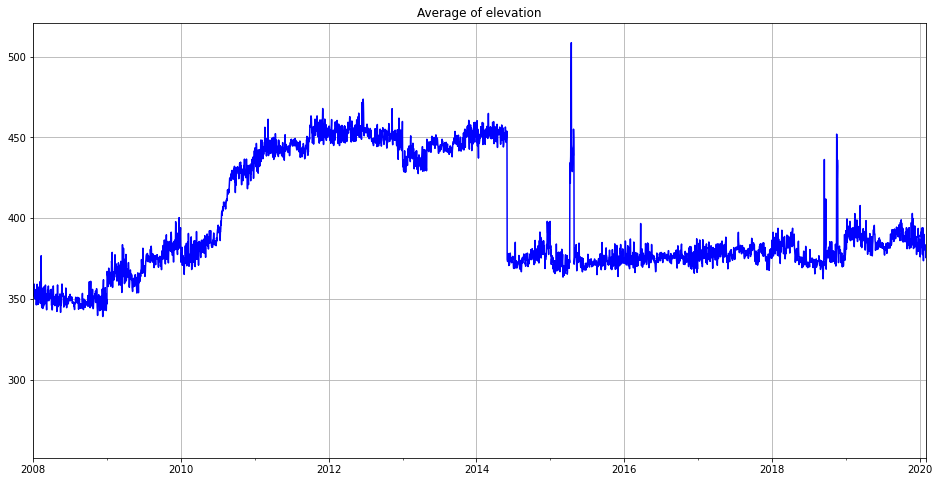

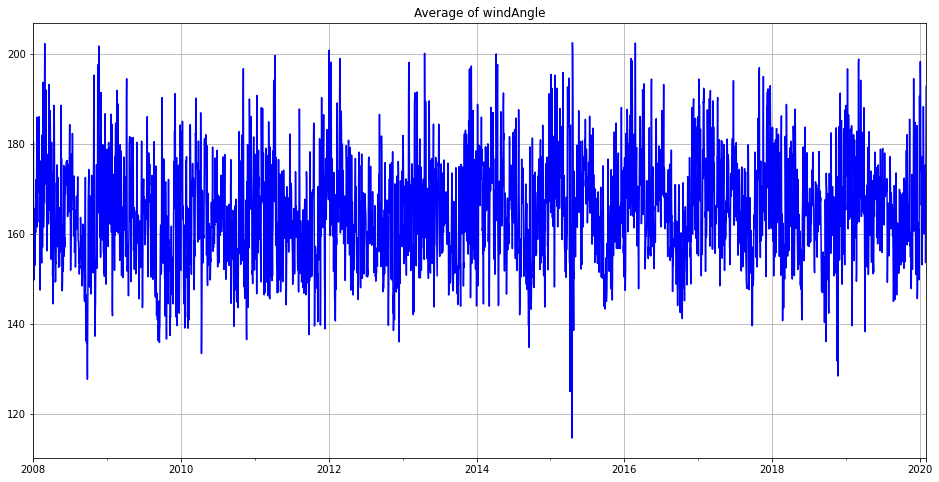

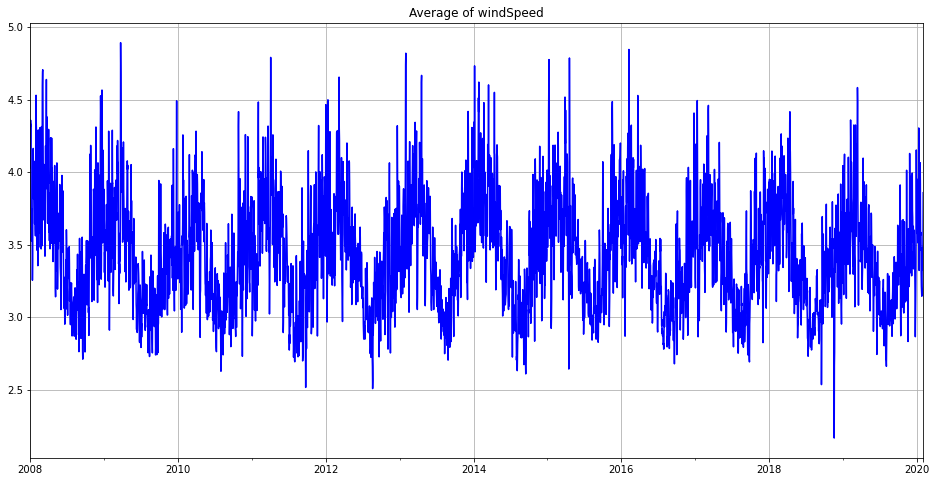

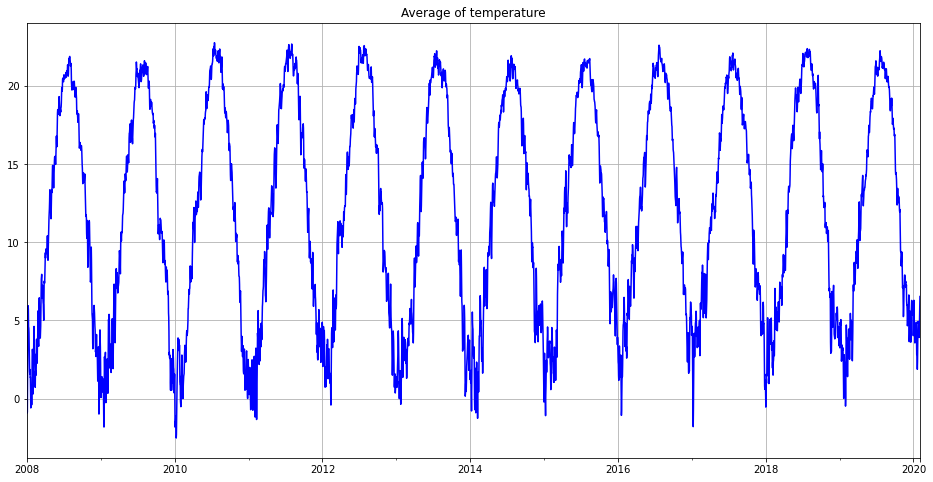

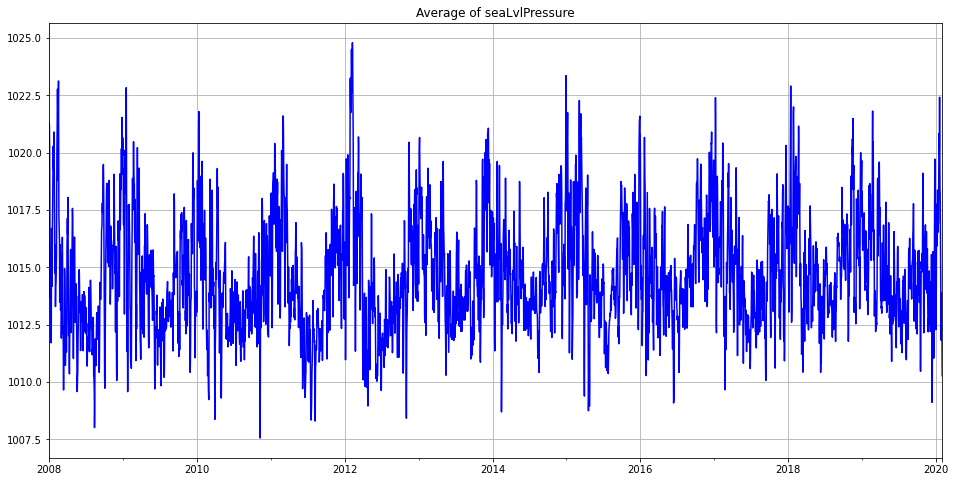

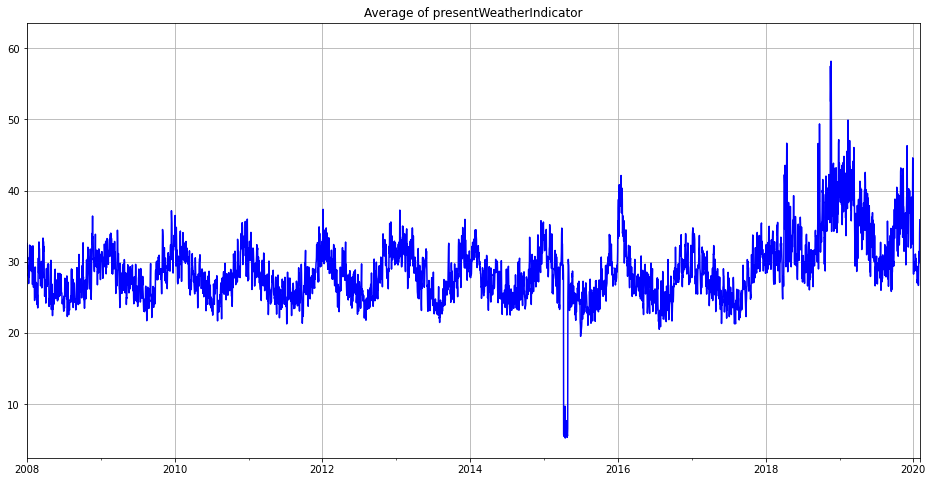

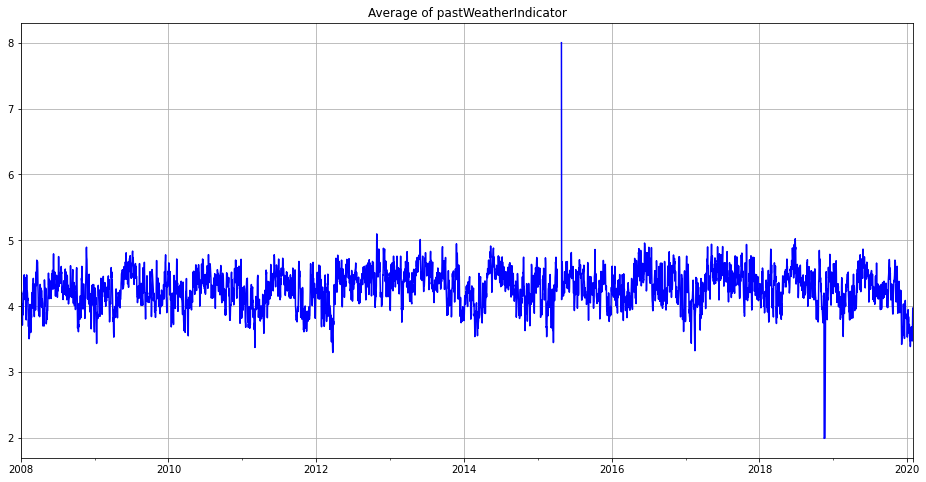

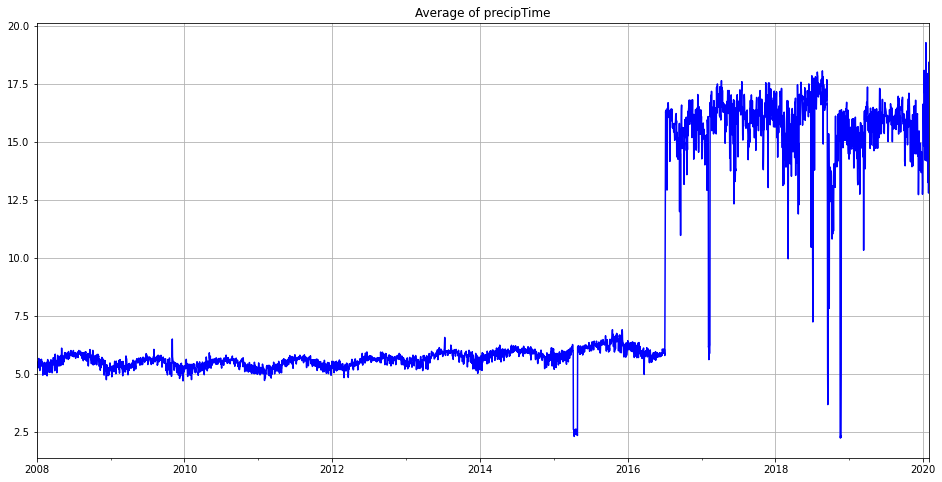

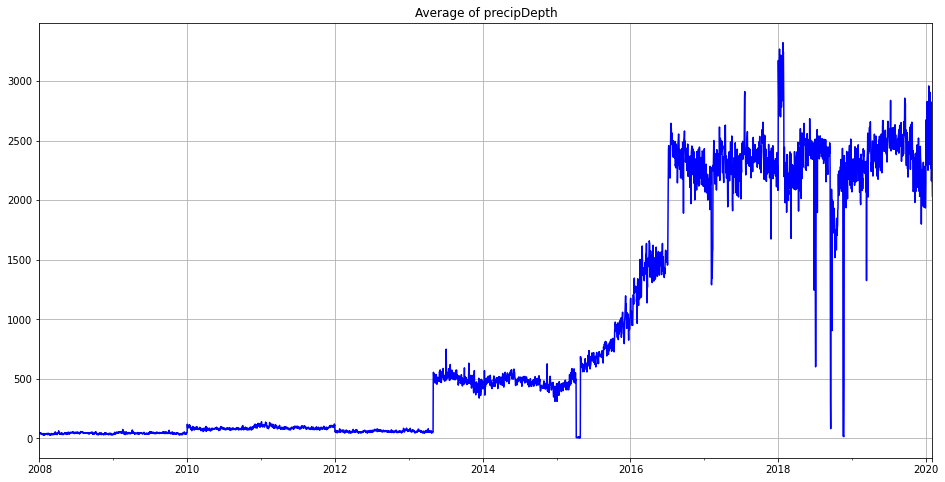

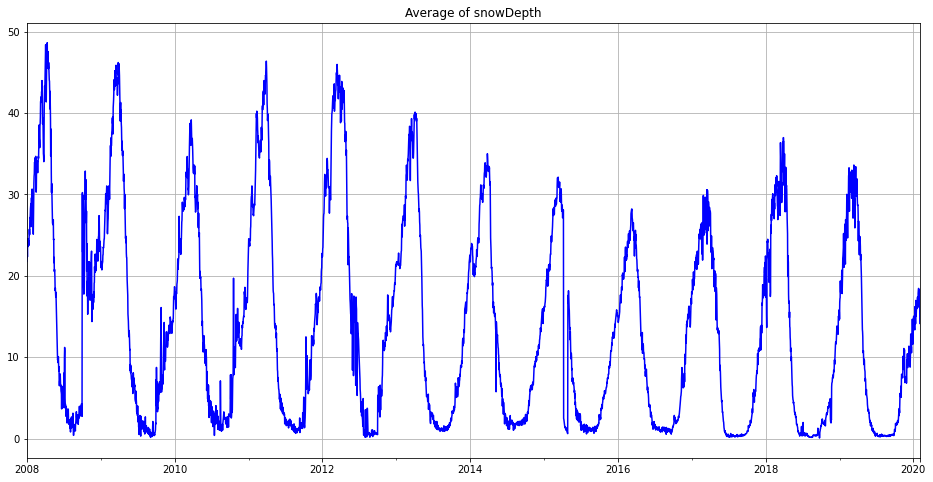

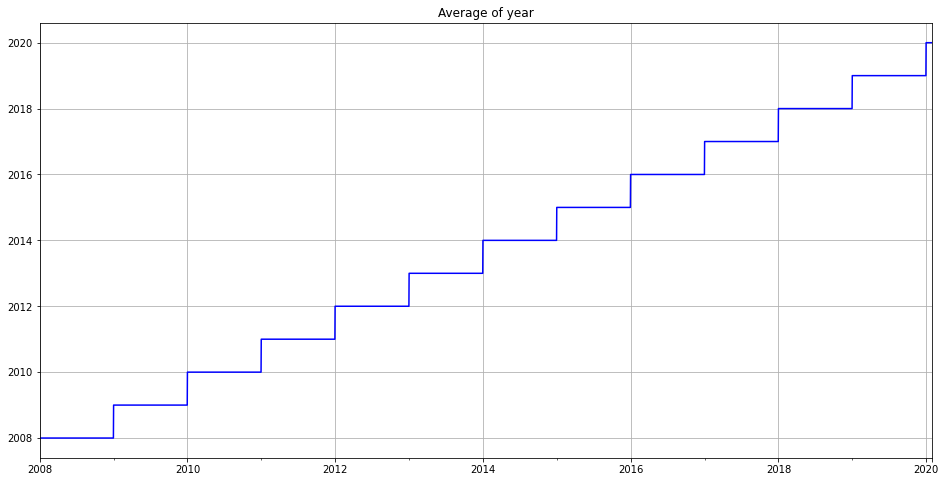

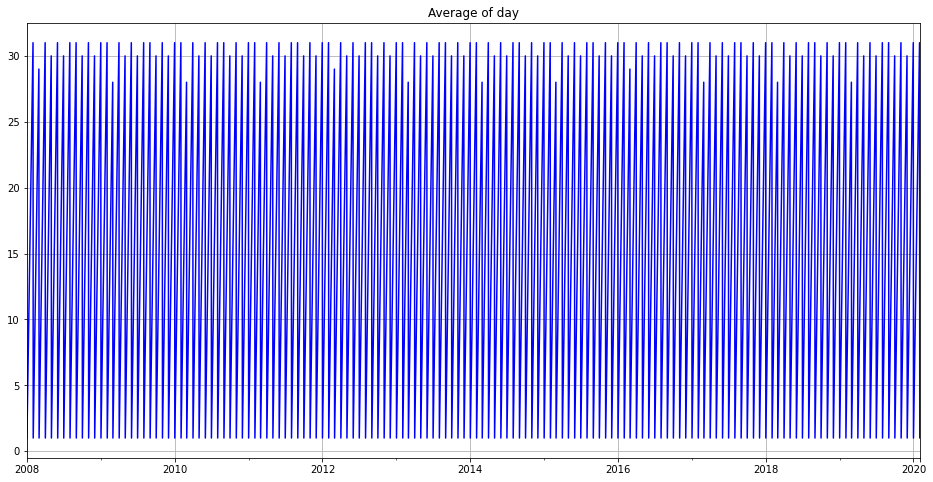

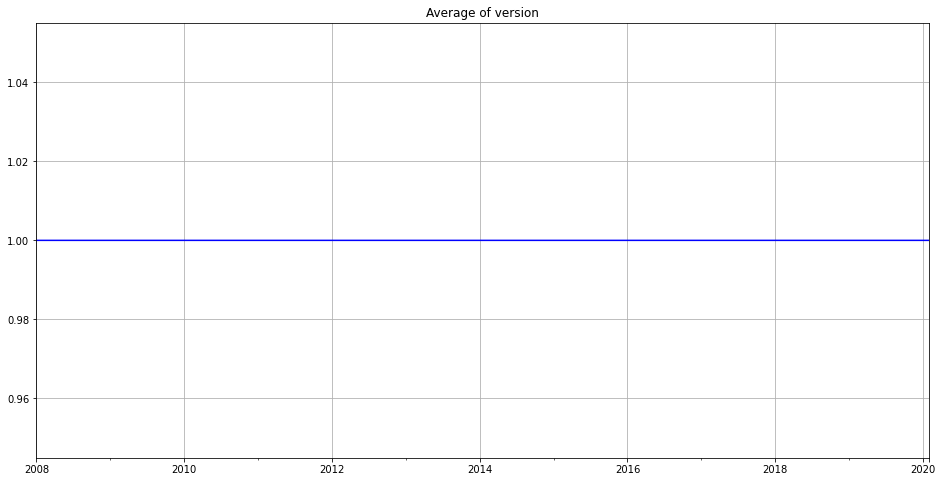

In [21]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2020, 2, 1)])
    plt.grid()
    
    # optionally, log the image to the run
    run.log_image(f'mean_{col}', plot=plt)

You can see the images logged to the run in the studio.

In [22]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-cloudprovider,dask-cloudprovider_1584247087_1e302380,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Transform data

In [23]:
## insert any Pandas-like Dask transformation code 
df['temperature'] = df['temperature']*(9/5)+32 # 'Merica

## Write data

**Warning**: This will write >150 GB of CSV files to your default storage account. 

In [24]:
%time df.to_csv(f'{protocol}://{container}/noaa-isd-csv/part-*-data.csv', storage_options=STORAGE_OPTIONS)

CPU times: user 5.76 s, sys: 756 ms, total: 6.51 s
Wall time: 38min 12s


['default/noaa-isd-csv/part-000-data.csv',
 'default/noaa-isd-csv/part-001-data.csv',
 'default/noaa-isd-csv/part-002-data.csv',
 'default/noaa-isd-csv/part-003-data.csv',
 'default/noaa-isd-csv/part-004-data.csv',
 'default/noaa-isd-csv/part-005-data.csv',
 'default/noaa-isd-csv/part-006-data.csv',
 'default/noaa-isd-csv/part-007-data.csv',
 'default/noaa-isd-csv/part-008-data.csv',
 'default/noaa-isd-csv/part-009-data.csv',
 'default/noaa-isd-csv/part-010-data.csv',
 'default/noaa-isd-csv/part-011-data.csv',
 'default/noaa-isd-csv/part-012-data.csv',
 'default/noaa-isd-csv/part-013-data.csv',
 'default/noaa-isd-csv/part-014-data.csv',
 'default/noaa-isd-csv/part-015-data.csv',
 'default/noaa-isd-csv/part-016-data.csv',
 'default/noaa-isd-csv/part-017-data.csv',
 'default/noaa-isd-csv/part-018-data.csv',
 'default/noaa-isd-csv/part-019-data.csv',
 'default/noaa-isd-csv/part-020-data.csv',
 'default/noaa-isd-csv/part-021-data.csv',
 'default/noaa-isd-csv/part-022-data.csv',
 'default/n

## Sample data & convert to Pandas dataframe

In [25]:
%time df2 = df[df['stationName'].str.contains('FLORIDA|WASHINGTON|TEXAS', regex=True, na=False)].compute()
df2

CPU times: user 2.18 s, sys: 466 ms, total: 2.65 s
Wall time: 1min 50s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
2008-01-04,725454,04903,2008-01-04 10:35:00,41.276,-91.667,230.0,200.0,6.7,28.40,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,4,1.0
2008-01-26,725454,04903,2008-01-26 04:15:00,41.276,-91.667,230.0,170.0,4.6,26.60,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,26,1.0
2008-01-08,725454,04903,2008-01-08 05:59:00,41.276,-91.667,230.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,8,1.0
2008-01-20,725454,04903,2008-01-20 02:35:00,41.276,-91.667,230.0,270.0,2.6,-0.40,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,20,1.0
2008-01-30,725454,04903,2008-01-30 22:15:00,41.276,-91.667,230.0,80.0,1.5,14.00,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,30,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-05,997736,99999,2020-03-05 15:00:00,43.380,-87.870,180.0,170.0,7.7,37.58,1013.2,...,NaN,NaN,NaN,NaN,PORT WASHINGTON,US,997736-99999,2020,5,1.0
2020-03-08,997736,99999,2020-03-08 19:00:00,43.380,-87.870,180.0,170.0,5.1,57.56,1018.3,...,NaN,NaN,NaN,NaN,PORT WASHINGTON,US,997736-99999,2020,8,1.0
2020-03-01,997736,99999,2020-03-01 00:00:00,43.380,-87.870,180.0,230.0,1.5,32.36,1019.6,...,NaN,NaN,NaN,NaN,PORT WASHINGTON,US,997736-99999,2020,1,1.0
2020-03-08,997736,99999,2020-03-08 05:00:00,43.380,-87.870,180.0,220.0,5.7,45.14,1023.7,...,NaN,NaN,NaN,NaN,PORT WASHINGTON,US,997736-99999,2020,8,1.0


In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3111141 entries, 2008-01-04 to 2020-03-06
Data columns (total 22 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   usaf                     object        
 1   wban                     object        
 2   datetime                 datetime64[ns]
 3   latitude                 float64       
 4   longitude                float64       
 5   elevation                float64       
 6   windAngle                float64       
 7   windSpeed                float64       
 8   temperature              float64       
 9   seaLvlPressure           float64       
 10  cloudCoverage            object        
 11  presentWeatherIndicator  float64       
 12  pastWeatherIndicator     float64       
 13  precipTime               float64       
 14  precipDepth              float64       
 15  snowDepth                float64       
 16  stationName              object        
 17  countryOrReg

## Create features for ML training

The below cells are for demo purposes only. The code is not good. The data science is not good. 

In [27]:
# begin data prep for ML 
df = df.fillna(0)

In [28]:
cols = list(df.columns)
cols = [col for col in cols if df.dtypes[col] != 'object' and col not in ['version', 'datetime']]
cols

['latitude',
 'longitude',
 'elevation',
 'windAngle',
 'windSpeed',
 'temperature',
 'seaLvlPressure',
 'presentWeatherIndicator',
 'pastWeatherIndicator',
 'precipTime',
 'precipDepth',
 'snowDepth',
 'year',
 'day']

In [29]:
X = df[[col for col in cols if col not in ['temperature']]].persist()
y = df.temperature.persist()
# end data prep for ML

## Train XGBoost model

In [30]:
xgb = XGBRegressor(n_estimators=16)
%time xgb.fit(X, y)

CPU times: user 2 s, sys: 285 ms, total: 2.28 s
Wall time: 12min 3s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=16, n_jobs=16, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [31]:
%time y_pred = xgb.predict(X).compute()

CPU times: user 6.75 s, sys: 4.62 s, total: 11.4 s
Wall time: 25.4 s


In [32]:
rmse = (((y.to_dask_array().compute()-y_pred)**2).mean())**.5
run.log('RMSE_XGBoost', rmse)
print(f'Training RMSE: {round(rmse, 3)}')

Training RMSE: 17.308


## Train LightGBM Model

In [33]:
lgbm = LGBMRegressor(n_estimators=16)
%time lgbm.fit(X, y)

WARNING - Parameter tree_learner not set or set to incorrect value (None), using "data" as default


CPU times: user 432 ms, sys: 62.8 ms, total: 495 ms
Wall time: 1min 56s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1,
              local_listen_port=12400,
              machines='10.0.0.14:12400,10.0.0.10:12401,10.0.0.12:12402,10.0.0.5:12403,10.0.0.25:12404,10.0.0.7:12405,10.0.0.16:12406,10.0.0.9:12407,10.0.0.27:12408,10.0.0.26:12409,10.0.0.6:12410,10.0.0.18:12411,10.0.0.15:12...:12417,10.0.0.28:12418,10.0.0.24:12419',
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=16, n_jobs=-1, num_leaves=31,
              num_machines=20, num_threads=16, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              time_out=120, tree_learner='data')

In [34]:
%time y_pred = lgbm.predict(X).compute()

CPU times: user 14.8 s, sys: 8.63 s, total: 23.4 s
Wall time: 40.3 s


In [35]:
rmse2 = (((y.to_dask_array().compute()-y_pred)**2).mean())**.5
run.log('RMSE_LightGBM', rmse2)
print(f'Training RMSE: {round(rmse2, 3)}')

Training RMSE: 18.344


## Evaluate models

In [36]:
if rmse2 < rmse:
    best_model = 'lgbm'
else:
    best_model = 'xgb'

best_model

'xgb'

## Register best model

In [37]:
model_path = f'{best_model}_noaa_isd.joblib.dat'
joblib.dump(xgb, model_path) if best_model is 'xgb' else joblib.dump(lgbm, model_path)
model2 = joblib.load(model_path)

In [38]:
model = Model.register(run.experiment.workspace, 
                       model_name      = f'{best_model}-noaa-isd', 
                       model_path      = model_path,
                       description     = f'NOAA ISD temperature predictor')

Registering model xgb-noaa-isd
